## Imports

In [126]:
import json
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import pos_tag
from string import punctuation
import re
from keras.utils import to_categorical
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from pandas_ml import ConfusionMatrix
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.layers import Embedding
# from keras.utils.np_utils import probas_to_classes
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
%matplotlib inline

from matplotlib import rcParams
from random import shuffle
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

## Loading Data

In [66]:
def load_data_from_json(filename):
    with open(filename,'r') as f:
        return json.load(f)

In [67]:
master_dict = load_data_from_json('dataset/task1_headline_ABSA_train.json')

In [68]:
master_dict

{'1': {'info': [{'aspects': "['Corporate/Appointment']",
    'sentiment_score': '-0.374',
    'snippets': "['set to step down']",
    'target': 'Royal Mail'}],
  'sentence': 'Royal Mail chairman Donald Brydon set to step down'},
 '100': {'info': [{'aspects': "['Market/Volatility/Volatility']",
    'sentiment_score': '-0.827',
    'snippets': "['down from record high']",
    'target': 'Weir'}],
  'sentence': 'Slump in Weir leads FTSE down from record high'},
 '1000': {'info': [{'aspects': "['Corporate/Regulatory']",
    'sentiment_score': '0.549',
    'snippets': "['FDA approval for key new lung cancer pill']",
    'target': 'AstraZeneca'}],
  'sentence': 'AstraZeneca wins FDA approval for key new lung cancer pill'},
 '1002': {'info': [{'aspects': "['Corporate/Stategy']",
    'sentiment_score': '-0.266',
    'snippets': "['cut 945 jobs as part of 3-year restructuring plan']",
    'target': 'Lloyds'}],
  'sentence': 'UPDATE 1-Lloyds to cut 945 jobs as part of 3-year restructuring plan'},

## Into Data

In [69]:
def extract_data_from_dict(master_dict):
    id_sentence = []
    sentence = []
    aspect = []
    target = []
    for key in master_dict.keys():
        id_sentence.append(int(key))
        sentence.append(master_dict[key]['sentence'])
        temp_target=[]
        temp_aspect = []
        for element in master_dict[key]['info']:
            temp_target.append(element['target'])
            temp_aspect.append(eval(element['aspects']))
        target.append(temp_target)
        aspect.append(temp_aspect)
    return id_sentence,sentence,aspect,target

In [70]:
id_sentence,sentence,aspect,target = extract_data_from_dict(master_dict)

In [71]:
len(id_sentence),len(sentence),len(aspect),len(target)

(438, 438, 438, 438)

In [72]:
#converting data into flat str
sentence_f = []
id_sentence_f = []
target_f = []
aspect_f = []
for a0 in zip(aspect,target,sentence,id_sentence):
    for a1 in zip(a0[0],a0[1]):
        for a2 in a1[0]:
            aspect_f.append(a2)
            target_f.append(a1[1])
            sentence_f.append(a0[2])
            id_sentence_f.append(a0[3])

In [73]:
len(id_sentence_f),len(sentence_f),len(target_f),len(aspect_f)

(537, 537, 537, 537)

TODO: Need to fix Correct Aspect 3 and under threat

In [74]:
for i,v in enumerate(aspect_f):
    if v == 'Correct Aspect 3' or v == 'under threat':
        aspect_f.pop(i)
        sentence_f.pop(i)
        id_sentence_f.pop(i)
        target_f.pop(i)

In [75]:
aspect_f_level1= []
aspect_f_level2=[]
for asp in aspect_f:
    try:
        aspect_f_level1.append(asp.split('/')[0])
        aspect_f_level2.append(asp.split('/')[1])
    except:
        print(asp)
# aspect_f

In [76]:
len(aspect_f_level2),len(aspect_f_level1)

(535, 535)

In [77]:
len(id_sentence_f),len(sentence_f),len(target_f),len(aspect_f)

(535, 535, 535, 535)

In [78]:
n_label_level_1 = len(set(aspect_f_level1))
n_label_level_2 = len(set(aspect_f_level2))
n_label_level_1,n_label_level_2

(4, 34)

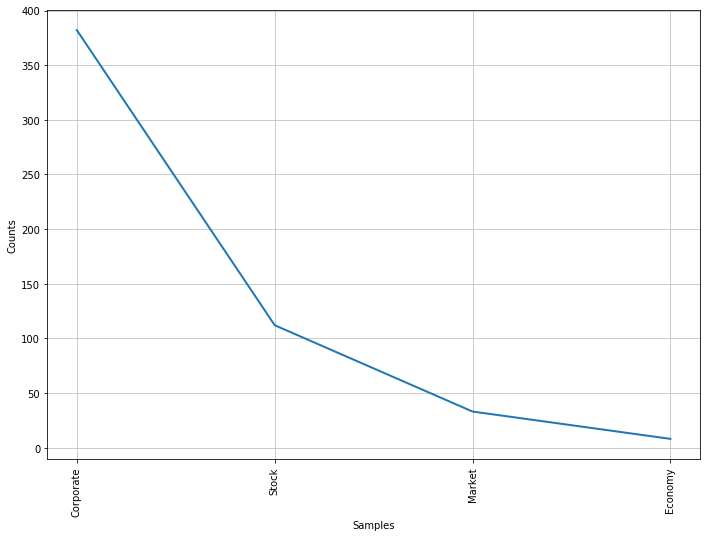

FreqDist({'Corporate': 382, 'Stock': 112, 'Market': 33, 'Economy': 8})


In [79]:
level1_freq = FreqDist(aspect_f_level1)
level1_freq.plot()
level1_freq.pprint()

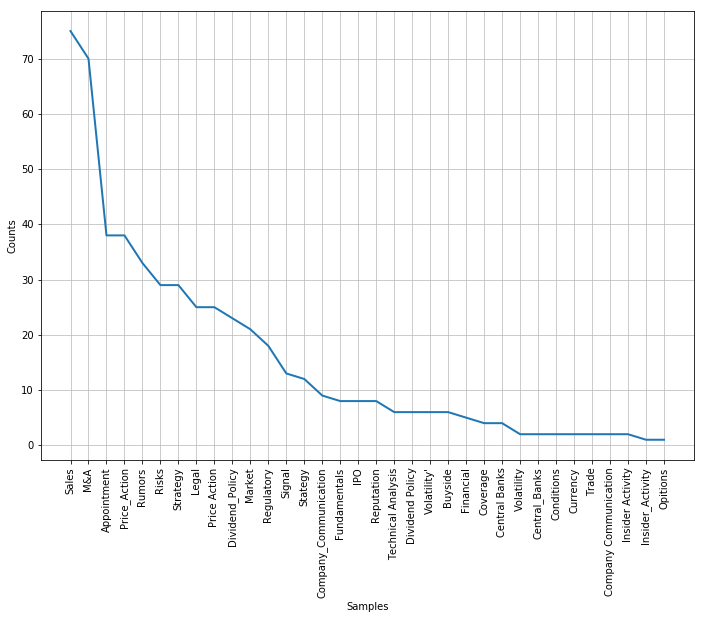

FreqDist({'Sales': 75, 'M&A': 70, 'Appointment': 38, 'Price_Action': 38, 'Rumors': 33, 'Risks': 29, 'Strategy': 29, 'Legal': 25, 'Price Action': 25, 'Dividend_Policy': 23, 'Market': 21, 'Regulatory': 18, 'Signal': 13, 'Stategy': 12, 'Company_Communication': 9, 'Fundamentals': 8, 'IPO': 8, 'Reputation': 8, 'Technical Analysis': 6, 'Dividend Policy': 6, "Volatility'": 6, 'Buyside': 6, 'Financial': 5, 'Coverage': 4, 'Central Banks': 4, 'Volatility': 2, 'Central_Banks': 2, 'Conditions': 2, 'Currency': 2, 'Trade': 2, 'Company Communication': 2, 'Insider Activity': 2, 'Insider_Activity': 1, 'Opitions': 1})


In [80]:
level2_freq = FreqDist(aspect_f_level2)
level2_freq.plot()
level2_freq.pprint(n_label_level_2)

In [89]:
def get_level_pairs(l1,l2):
    level_pair = dict()
    for pair in zip(l1,l2):
        if pair[1] in level_pair.keys():
            level_pair[pair[1]].append(pair[0])
        else:
            level_pair[pair[1]] = [pair[0]]
    for _ in level_pair.keys():
        level_pair[_] = list(set(level_pair[_]))
    return level_pair

In [90]:
L2_L1_pair = get_level_pairs(aspect_f_level1,aspect_f_level2)
L1_L2_pair = get_level_pairs(aspect_f_level2,aspect_f_level1)

In [91]:
L1_L2_pair

{'Corporate': ['Appointment',
  'Legal',
  'Risks',
  'Stategy',
  'Regulatory',
  'Company_Communication',
  'M&A',
  'Dividend Policy',
  'Rumors',
  'Financial',
  'Reputation',
  'Dividend_Policy',
  'Strategy',
  'Company Communication',
  'Sales'],
 'Economy': ['Central_Banks', 'Trade', 'Central Banks'],
 'Market': ['Volatility', 'Conditions', 'Market', "Volatility'", 'Currency'],
 'Stock': ['Price_Action',
  'Buyside',
  'Signal',
  'Technical Analysis',
  'Opitions',
  'Coverage',
  'Fundamentals',
  'Price Action',
  'Insider_Activity',
  'Insider Activity',
  'IPO']}

In [92]:
L2_L1_pair

{'Appointment': ['Corporate'],
 'Buyside': ['Stock'],
 'Central Banks': ['Economy'],
 'Central_Banks': ['Economy'],
 'Company Communication': ['Corporate'],
 'Company_Communication': ['Corporate'],
 'Conditions': ['Market'],
 'Coverage': ['Stock'],
 'Currency': ['Market'],
 'Dividend Policy': ['Corporate'],
 'Dividend_Policy': ['Corporate'],
 'Financial': ['Corporate'],
 'Fundamentals': ['Stock'],
 'IPO': ['Stock'],
 'Insider Activity': ['Stock'],
 'Insider_Activity': ['Stock'],
 'Legal': ['Corporate'],
 'M&A': ['Corporate'],
 'Market': ['Market'],
 'Opitions': ['Stock'],
 'Price Action': ['Stock'],
 'Price_Action': ['Stock'],
 'Regulatory': ['Corporate'],
 'Reputation': ['Corporate'],
 'Risks': ['Corporate'],
 'Rumors': ['Corporate'],
 'Sales': ['Corporate'],
 'Signal': ['Stock'],
 'Stategy': ['Corporate'],
 'Strategy': ['Corporate'],
 'Technical Analysis': ['Stock'],
 'Trade': ['Economy'],
 'Volatility': ['Market'],
 "Volatility'": ['Market']}

In [93]:
#checking pos tags of target and there freq
target_tags_freq = dict()
for s in sentence_f:
    text = word_tokenize(s)
    for pair in pos_tag(text):
        if pair[0] in target_f:
            if pair[1] in target_tags_freq.keys():
                target_tags_freq[pair[1]]+=1
            else:
                target_tags_freq[pair[1]] =1
target_tags_freq

{'JJ': 12, 'NN': 21, 'NNP': 532, 'NNS': 20, 'RB': 2, 'VB': 3, 'VBP': 1}

In [94]:
#number of words having same pos tags but not target
count = 0
for s in sentence_f:
    text = word_tokenize(s)
    for pair in pos_tag(text):
        if pair[1] in target_tags_freq.keys() and pair[0] not in target_f:
            count+=1
count

3200

## pre-processing data

In [95]:
def clean_sentence(sentence):
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"(?:\@|https?\://)\S+", "", sentence)
    #removing stock names to see if it helps
    sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [96]:
sentenceX = [clean_sentence(x) for x in sentence_f]

In [97]:
sentenceX

['Royal Mail chairman Donald Brydon set step',
 'Stakes High AstraZeneca Heart Drug Facing Tough Competition',
 'UPDATE 1Dairy Crest loses third Morrisons milk contract',
 'Insight hires Avivas David Hillier multiasset team',
 'Primark racks happy Christmas strong sales',
 'UPDATE 1Pearson expects grow year solid end 2014',
 'Tesco sells Blinkbox broadband service TalkTalk',
 'Tesco sells Blinkbox broadband service TalkTalk',
 'Unilever profit rises despite sales slump China',
 'Tesco leads leap FTSE 100 Marks Spencer drops',
 'Royal Dutch Shell profit rises dividend',
 'Morning Agenda Shires Deal NPS',
 'Carnival Corporation China Merchants Group Sign Memo Understanding',
 'Teva FDA Approves Generic Version AstraZeneca Heartburn Drug',
 'Teva FDA Approves Generic Version AstraZeneca Heartburn Drug',
 'Passengers rise EasyJet Aer Lingus',
 'Tesco Abandons VideoStreaming Ambitions Blinkbox Sale',
 'Tesco Abandons VideoStreaming Ambitions Blinkbox Sale',
 'FDA approves NPS drug move vali

In [98]:
Level_1Y = aspect_f_level1
Level_2Y = aspect_f_level2

In [99]:
lengths = [len(s.split()) for s in sentenceX]

max len =  17


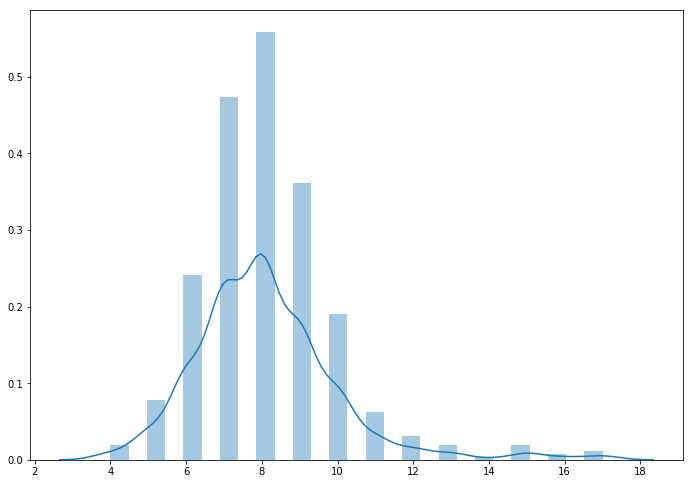

In [100]:
print('max len = ',max(lengths))
sns.distplot(lengths)

In [101]:
max_length  = 12

## Model

In [102]:
tranLines = sentenceX
trainLabels = aspect_f_level2

In [103]:
no_of_classes = n_label_level_2
no_of_classes

34

In [104]:
trainX,testX = tranLines[:int(len(tranLines)*0.9)],tranLines[int(len(tranLines)*0.9):]
trainY,testY = trainLabels[:int(len(trainLabels)*0.9)],trainLabels[int(len(trainLabels)*0.9):]

In [105]:
print(len(trainX),len(trainY))
print(len(testX),len(testY))

481 481
54 54


In [106]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [107]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [108]:
# create tokenizer
tokenizer = create_tokenizer(trainX)
# calculate max document length
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainX, max_length)
testX = encode_text(tokenizer, testX, max_length)
print(trainX.shape,testX.shape)

Max document length: 12
Vocabulary size: 1532
(481, 12) (54, 12)


In [113]:
def convert_lables(trainY,testY):
    le = preprocessing.LabelEncoder()
    le.fit(trainY+testY#loading Google Word2Vec
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)def get_word2vec_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrixword2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')
embedding_matrix_word2vec = get_word2vec_embedding_matrix(word2vec_model)def defina_model():



    lstm_out = 400
    model = Sequential()
    model.add(Embedding(vocab_size,300,weights=[embedding_matrix_word2vec],input_length=max_length,trainable = False))
    model.add(Bidirectional(LSTM(lstm_out, recurrent_dropout=0.2)))
    model.add(Dense(400,activation='relu'))
    model.add(Dense(200,activation='relu'))
    model.add(Dense(no_of_classes,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    print(model.summary())
    return model)
#     print(le.classes_)
    temp1 = le.transform(trainY)
    temp2 = le.transform(testY)
    return to_categorical(temp1,no_of_classes),to_categorical(temp2,no_of_classes),le.classes_

In [114]:
trainY,testY,lable_encoding = convert_lables(trainY,testY)

In [115]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [116]:
def get_word2vec_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [117]:
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')
embedding_matrix_word2vec = get_word2vec_embedding_matrix(word2vec_model)

In [133]:
def defina_model():
    lstm_out = 400
    model = Sequential()
    model.add(Embedding(vocab_size,300,weights=[embedding_matrix_word2vec],input_length=max_length,trainable = False))
    model.add(Bidirectional(LSTM(lstm_out, recurrent_dropout=0.2)))
    model.add(Dense(400,activation='relu'))
    model.add(Dense(200,activation='relu'))
    model.add(Dense(no_of_classes,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    print(model.summary())
    return model

In [134]:
model = defina_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 12, 300)           459600    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 800)               2243200   
_________________________________________________________________
dense_4 (Dense)              (None, 400)               320400    
_________________________________________________________________
dense_5 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_6 (Dense)              (None, 34)                6834      
Total params: 3,110,234
Trainable params: 2,650,634
Non-trainable params: 459,600
_________________________________________________________________
None


In [135]:
history_object = model.fit(trainX, trainY, epochs=50,batch_size=16)

Epoch 1/50
481/481 [==============================] - 6s 12ms/step - loss: 3.1443 - acc: 0.1642
Epoch 2/50
481/481 [==============================] - 5s 10ms/step - loss: 2.4389 - acc: 0.3909
Epoch 3/50
481/481 [==============================] - 5s 10ms/step - loss: 2.0083 - acc: 0.4449
Epoch 4/50
481/481 [==============================] - 5s 10ms/step - loss: 1.6148 - acc: 0.5572
Epoch 5/50
481/481 [==============================] - 5s 10ms/step - loss: 1.2460 - acc: 0.6570
Epoch 6/50
481/481 [==============================] - 5s 10ms/step - loss: 1.1476 - acc: 0.6715
Epoch 7/50
481/481 [==============================] - 5s 10ms/step - loss: 0.8987 - acc: 0.7526
Epoch 8/50
481/481 [==============================] - 5s 10ms/step - loss: 1.0155 - acc: 0.7193
Epoch 9/50
481/481 [==============================] - 5s 10ms/step - loss: 0.7864 - acc: 0.7422
Epoch 10/50
481/481 [==============================] - 5s 10ms/step - loss: 0.5762 - acc: 0.8441
Epoch 11/50
481/481 [==================

In [136]:
model.evaluate(testX,testY)

54/54 [==============================] - 0s 6ms/step


[3.352343029446072, 0.46296295192506576]

In [137]:
pred = model.predict(testX)

In [138]:
test_label_act = [lable_encoding[x.argmax()] for x in testY]
test_label_pred = [lable_encoding[x.argmax()] for x in pred]

In [139]:
cnf_matrix = confusion_matrix(test_label_act, test_label_pred)
cnf_matrix

array([[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0],
       [0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0

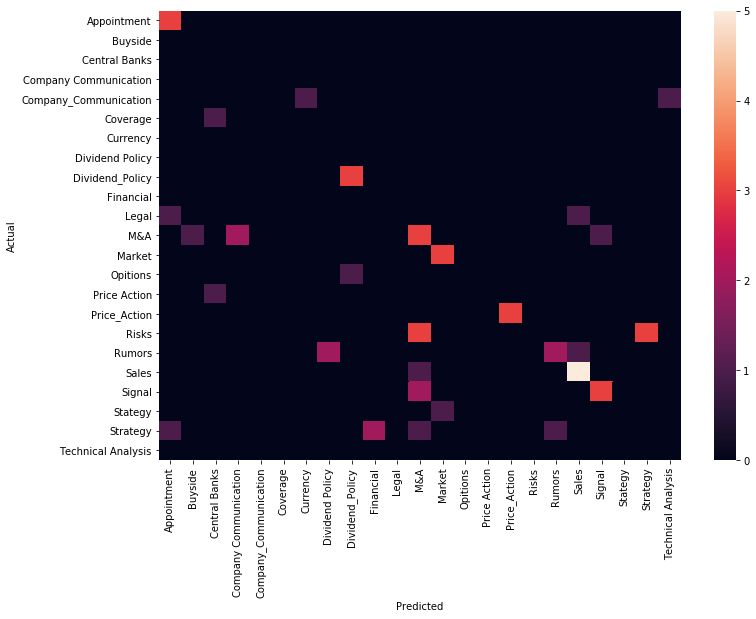

In [141]:
ConfusionMatrix(test_label_act, test_label_pred).plot(backend='seaborn')

In [142]:
#get metric scores
def print_metric(yacc,ypred,avg_type):
    print('---------------------avg type = {0}---------------------------------------------'.format(avg_type))
    print('F1 score == ', f1_score(yacc,ypred,average=avg_type))
    print('precision score == ', precision_score(yacc,ypred,average=avg_type))
    print('recall score == ', recall_score(yacc,ypred,average=avg_type))
    print('accuracy score == ', accuracy_score(yacc,ypred))

In [143]:
# print_metric(test_label_act,test_label_pred,'micro')
print_metric(test_label_act,test_label_pred,'macro')
print_metric(test_label_act,test_label_pred,'weighted')

---------------------avg type = macro---------------------------------------------
F1 score ==  0.250135840289293
precision score ==  0.2404761904761905
recall score ==  0.2722567287784679
accuracy score ==  0.46296296296296297
---------------------avg type = weighted---------------------------------------------
F1 score ==  0.43170672827535567
precision score ==  0.4216490299823633
recall score ==  0.46296296296296297
accuracy score ==  0.46296296296296297


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
